<a href="https://colab.research.google.com/github/Rolfrider/Android-countries/blob/master/MapSPDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
!pip install plotly_express

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [67]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

Pobranie grafu reprezentującego wszystkie ulice Warszawy

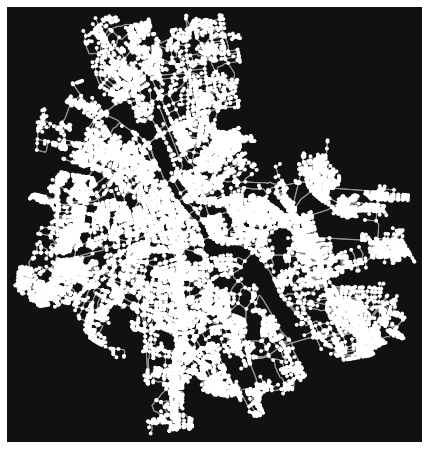

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [68]:
warsaw_streets = ox.graph_from_place("Warsaw", network_type="drive")
ox.plot_graph(warsaw_streets)

Node ma x - longitude i y - latitude

Tutaj wyświetlam jakiś losowy node


In [69]:
warsaw_streets.nodes[26083941]


{'osmid': 26083941, 'x': 21.0211398, 'y': 52.1614477}

Edge są to najczęściej ulice lub ich części, bo warto pamiętać, że edge jest pomiędzy dwoma Node

Jednak nie zawsze musi to być ulica z nazwą i liczbą pasów (lanes) i geometrią(to chyba krztałt ulicy)

Lenght to odległość wyrażona w metrach

In [70]:
warsaw_streets.edges[(26063856, 1439574271, 0)]

{'geometry': <shapely.geometry.linestring.LineString at 0x7f3e67ac35c0>,
 'highway': 'tertiary',
 'lanes': '2',
 'length': 334.097,
 'name': 'Kłobucka',
 'oneway': False,
 'osmid': 759434131}

Aby dodać czas potrzebny na przebycie krawędzi, musimy dodać najpierw dopuszczalne prędkości(gdy ich nie ma bo nie jest to dorga czy coś to wtedy jest dawana jakaś prędkość średnia). Następnie dodanie czasu podróży opiera się na podzieleniu odległości przez prędkość. Teraz w pokazanym edge widać również speed w km/h i czas w sekundach.

In [71]:
warsaw_streets = ox.add_edge_speeds(warsaw_streets)
warsaw_streets = ox.add_edge_travel_times(warsaw_streets)
warsaw_streets.edges[(26063856, 1439574271, 0)]

{'geometry': <shapely.geometry.linestring.LineString at 0x7f3e67ac35c0>,
 'highway': 'tertiary',
 'lanes': '2',
 'length': 334.097,
 'name': 'Kłobucka',
 'oneway': False,
 'osmid': 759434131,
 'speed_kph': 48.1,
 'travel_time': 25.0}

In [72]:
start_node = ox.get_nearest_node(warsaw_streets, (52.1634477, 21.0221398))
end_node = ox.get_nearest_node(warsaw_streets, (52.1614477, 21.1211398))
print(start_node)
print(end_node)

3594622835
7797405975


In [73]:
route = nx.shortest_path(warsaw_streets, start_node, end_node, weight='travel_time')
route

[3594622835,
 3594622827,
 260824074,
 26083947,
 427569370,
 26083941,
 26083942,
 427569369,
 26083946,
 300116308,
 1170530978,
 1419987379,
 32022081,
 32022055,
 32022056,
 32022028,
 280282334,
 251907279,
 32022057,
 26485601,
 251963025,
 32124419,
 251963338,
 32124420,
 1846199620,
 32320927,
 32320928,
 1818966213,
 356989405,
 356989435,
 251949222,
 2452220922,
 32676751,
 2717353599,
 897143892,
 897144215,
 897143868,
 32676786,
 248887423,
 778785665,
 340564632,
 3115362672,
 5784242412,
 5784242406,
 32675833,
 32675834,
 778789581,
 1108549722,
 428474231,
 1108549579,
 308044836,
 59815940,
 59815941,
 5163831702,
 4882187073,
 2811291179,
 4882187057,
 324969221,
 2031916189,
 276251984,
 1166432596,
 7797405980,
 7797405969,
 7797405971,
 7797405973,
 7797405975]

Tak można wyświetlić przykładową trase na grafie

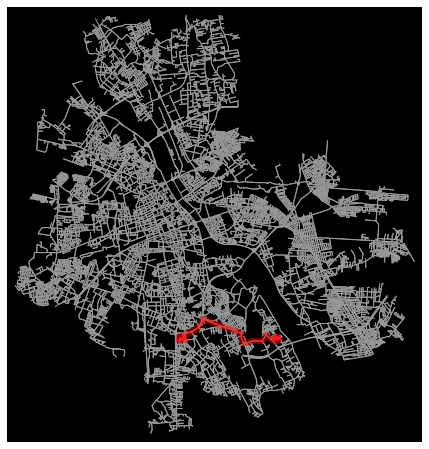

In [74]:
ox.plot_graph_route(warsaw_streets, route, route_linewidth=6, node_size = 0, bgcolor='k');

Teraz jak to pokazać na mapie

In [76]:
gdf_edges = ox.graph_to_gdfs(ox.project_graph(warsaw_streets), nodes=False)
gdf_edges.head()

,osmid,oneway,highway,length,speed_kph,travel_time,geometry,lanes,ref,name,maxspeed,access,junction,bridge,tunnel,width,service,u,v,key
0,4895484,True,secondary,25.021,50.9,1.8,"LINESTRING (501194.157 5778031.972, 501217.735...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26063726,31717945,0
1,148749604,True,primary,332.479,50.0,23.9,"LINESTRING (501194.157 5778031.972, 501194.162...",3,2,Puławska,50,NaN,NaN,NaN,NaN,NaN,NaN,26063726,29273144,0
2,144840744,True,primary,18.993,50.0,1.4,"LINESTRING (501217.735 5778023.413, 501219.995...",3,2,Puławska,50,NaN,NaN,NaN,NaN,NaN,NaN,31717945,26195490,0
3,446671927,True,secondary,57.716,50.0,4.2,"LINESTRING (501217.735 5778023.413, 501231.967...",2,NaN,Rotmistrza Witolda Pileckiego,50,NaN,NaN,NaN,NaN,NaN,NaN,31717945,270313037,0
4,148749604,True,primary,262.620,50.0,18.9,"LINESTRING (501196.802 5777699.419, 501199.268...",3,2,Puławska,50,NaN,NaN,NaN,NaN,NaN,NaN,29273144,273611324,0


Tutaj w zasadzie grupujemy dane z wcześniej wyznaczonej trasy


In [78]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(warsaw_streets.edges[(u, v, 0)]['length']))
    travel_time.append(round(warsaw_streets.edges[(u, v, 0)]['travel_time']))
    X_from.append(warsaw_streets.nodes[u]['x'])
    Y_from.append(warsaw_streets.nodes[u]['y'])
    X_to.append(warsaw_streets.nodes[v]['x'])
    Y_to.append(warsaw_streets.nodes[v]['y'])

Tworzymy data frame (tabelke)

In [79]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,3594622835,3594622827,21.022332,52.163138,21.022001,52.162806,43,7
1,3594622827,260824074,21.022001,52.162806,21.020822,52.161883,163,25
2,260824074,26083947,21.020822,52.161883,21.020733,52.161754,16,1
3,26083947,427569370,21.020733,52.161754,21.021066,52.161568,31,3
4,427569370,26083941,21.021066,52.161568,21.021140,52.161448,15,1


In [80]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,3594622835,3594622827,21.022332,52.163138,21.022001,52.162806,43,7
1,1,3594622827,260824074,21.022001,52.162806,21.020822,52.161883,163,25
2,2,260824074,26083947,21.020822,52.161883,21.020733,52.161754,16,1
3,3,26083947,427569370,21.020733,52.161754,21.021066,52.161568,31,3
4,4,427569370,26083941,21.021066,52.161568,21.021140,52.161448,15,1


In [81]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    return line_gdf

<AxesSubplot:>

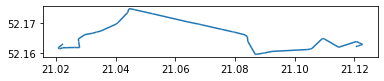

In [86]:
line_gdf = create_line_gdf(df)
line_gdf.plot()

In [83]:
line_gdf.head()

,node_start,node_end,length,travel_time,line
0,3594622835,3594622827,43,7,"LINESTRING (21.02200 52.16281, 21.02233 52.16314)"
1,3594622827,260824074,163,25,"LINESTRING (21.02082 52.16188, 21.02200 52.16281)"
2,260824074,26083947,16,1,"LINESTRING (21.02073 52.16175, 21.02082 52.16188)"
3,26083947,427569370,31,3,"LINESTRING (21.02107 52.16157, 21.02073 52.16175)"
4,427569370,26083941,15,1,"LINESTRING (21.02114 52.16145, 21.02107 52.16157)"


In [90]:
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
0,0,3594622835,3594622827,21.022332,52.163138,21.022001,52.162806,43,7,POINT (21.02233 52.16314),POINT (21.022001 52.1628056)
1,1,3594622827,260824074,21.022001,52.162806,21.020822,52.161883,163,25,POINT (21.02200 52.16281),POINT (21.0208219 52.1618833)
2,2,260824074,26083947,21.020822,52.161883,21.020733,52.161754,16,1,POINT (21.02082 52.16188),POINT (21.0207334 52.1617538)
3,3,26083947,427569370,21.020733,52.161754,21.021066,52.161568,31,3,POINT (21.02073 52.16175),POINT (21.0210665 52.1615676)
4,4,427569370,26083941,21.021066,52.161568,21.021140,52.161448,15,1,POINT (21.02107 52.16157),POINT (21.0211398 52.1614477)


Tak można na mapie punkty zaznaczyć

In [101]:
px.set_mapbox_access_token("pk.eyJ1Ijoicm9sZnJpZGVyIiwiYSI6ImNraWhmYTYxZjBvaHIycW1xdnN3Zmc2ZHMifQ.NKrgwgvKvbbGuaYMfrOsrw")
fig = px.scatter_mapbox(df, lat="Y_from", lon="X_from",
                  color_continuous_scale=px.colors.cyclical.IceFire, zoom=12)
fig.show()

A tak je połączyć

In [97]:
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])

A można nawet zrobić animacje jak się jedzie xD

In [91]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [100]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=11, animation_frame="index")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig